In [1]:
import numpy as np
import pandas as pd
import sklearn.metrics
import sklearn.linear_model
import sklearn.decomposition

import os
import tqdm
import matplotlib.pyplot as plt

from src import Selector

chromosome_list = [str(i) for i in range(1, 23)] + ["X"]
hash_idx_max = {
    "1": 249000,  "2": 243000,  "3": 199000,  "4": 191000,
    "5": 182000,  "6": 171000,  "7": 160000,  "8": 146000,
    "9": 139000, "10": 134000, "11": 136000, "12": 134000,
    "13": 115000, "14": 108000, "15": 102000, "16":  91000,
    "17":  84000, "18":  81000, "19":  59000, "20":  65000,
    "21":  47000, "22":  51000,  "X": 157000,
}

# Profile

In [3]:
# { chromosome : (hash_idx, bucket_idx, distance) }
feature = Selector("data/feature").getFeature()
# remove distance and ndarray dtype from float to int
# { chromosome : (hash_idx, bucket_idx) }
feature = {c: np.array([f[:2] for f in feature[c]], dtype=int) for c in feature}
result = []
for c in chromosome_list:
    for hash_idx, bucket_idx in feature[c]:
        result.append((c, hash_idx*1000 + bucket_idx*100, hash_idx*1000 + (bucket_idx+1)*100))
result = pd.DataFrame(result, columns=["chromosome", "start", "end"])
result.to_csv("data/temp/feature.csv", index=False)

In [2]:
## bed
# read bed file
bed = pd.read_csv(
    "data/temp/rgc_gxs_v1_hg38.bed", 
    sep="\t", header=0, names=["chromosome", "start", "end"]
)
# remove chr prefix
bed["chromosome"] = bed["chromosome"].apply(lambda x: x[3:])
# keep chromosome 1-22 and X
bed = bed[bed['chromosome'].isin(chromosome_list)]
# transform bed from range list to one hot
bed_one_hot = {
    c: np.zeros((hash_idx_max[c] * 1000), dtype=bool) for c in chromosome_list
}
for _, row in bed.iterrows():
    chromosome, start, end = row[['chromosome', 'start', 'end']]
    bed_one_hot[chromosome][start:end] = True

## feature
# { chromosome : (hash_idx, bucket_idx, distance) }
feature = Selector("data/feature").getFeature()
# remove distance and ndarray dtype from float to int
# { chromosome : (hash_idx, bucket_idx) }
feature = {c: np.array([f[:2] for f in feature[c]], dtype=int) for c in feature}
# transform feature from bucket list to one hot
feature_one_hot = {
    c: np.zeros((hash_idx_max[c] * 1000), dtype=bool) for c in chromosome_list
}
for c in feature:
    for hash_idx, bucket_idx in feature[c]:
        feature_one_hot[c][
            hash_idx*1000 + bucket_idx*100 : hash_idx*1000 + (bucket_idx+1)*100
        ] = True

# calculate overlap
for c in bed_one_hot:
    overlap = np.logical_and(bed_one_hot[c], feature_one_hot[c])
    overlap_bed = (np.sum(overlap) / np.sum(bed_one_hot[c])) * 100 
    overlap_feature = (np.sum(overlap) / np.sum(feature_one_hot[c])) * 100
    print(
        f"Chromosome {c}:\t",
        f"overlap/bed: {np.sum(overlap):7,} / {np.sum(bed_one_hot[c]):9,} = {overlap_bed:5.2f}%\t",
        f"overlap/feature: {np.sum(overlap):7,} / {np.sum(feature_one_hot[c]):9,} = {overlap_feature:5.2f}%"
    )

Chromosome 1:	 overlap/bed: 223,317 / 5,925,469 =  3.77%	 overlap/feature: 223,317 / 7,193,700 =  3.10%
Chromosome 2:	 overlap/bed: 235,007 / 6,232,810 =  3.77%	 overlap/feature: 235,007 / 7,379,000 =  3.18%
Chromosome 3:	 overlap/bed: 175,064 / 5,125,520 =  3.42%	 overlap/feature: 175,064 / 5,489,800 =  3.19%
Chromosome 4:	 overlap/bed: 148,745 / 4,596,187 =  3.24%	 overlap/feature: 148,745 / 5,005,900 =  2.97%
Chromosome 5:	 overlap/bed: 155,752 / 4,408,031 =  3.53%	 overlap/feature: 155,752 / 5,045,600 =  3.09%
Chromosome 6:	 overlap/bed: 855,841 / 6,491,030 = 13.18%	 overlap/feature: 855,841 / 7,447,300 = 11.49%
Chromosome 7:	 overlap/bed: 151,134 / 4,126,010 =  3.66%	 overlap/feature: 151,134 / 4,516,900 =  3.35%
Chromosome 8:	 overlap/bed: 138,374 / 3,762,151 =  3.68%	 overlap/feature: 138,374 / 4,227,000 =  3.27%
Chromosome 9:	 overlap/bed: 135,313 / 3,121,515 =  4.33%	 overlap/feature: 135,313 / 3,739,600 =  3.62%
Chromosome 10:	 overlap/bed: 127,546 / 3,621,313 =  3.52%	 overl

In [3]:
p_val = 1e-3

snps = pd.read_csv("data/snps.csv", usecols=["Chr", "Pos", "Pval"])
# filter by pval < 1e-3
snps = snps[snps["Pval"] < p_val][["Chr", "Pos"]]
# sort by Chr and then Pos
snps = snps.sort_values(["Chr", "Pos"])
# transform chromosome from int 1-23 to str 1-22, X
snps["Chr"] = snps["Chr"].apply(lambda x: str(x) if x < 23 else "X")
# split by chromosome, { chromosome : (pos) }
snps = snps.groupby("Chr")["Pos"].apply(list).to_dict()

for c, pos in snps.items():
    snps_in_bed, snps_in_feature = 0, 0
    for p in pos:
        if bed_one_hot[c][p]: snps_in_bed += 1
        if feature_one_hot[c][p]: snps_in_feature += 1
    print(
        f"Chromosome {c}:\t",
        f"snps_in_bed/bed: {snps_in_bed:6,} / {len(pos):6,} = {(snps_in_bed / len(pos)) * 100:5.2f}%\t",
        f"snps_in_feature/feature: {snps_in_feature:6,} / {len(pos):6,} = {(snps_in_feature / len(pos)) * 100:5.2f}%"
    )

Chromosome 1:	 snps_in_bed/bed:  1,586 / 37,485 =  4.23%	 snps_in_feature/feature: 37,138 / 37,485 = 99.07%
Chromosome 10:	 snps_in_bed/bed:    857 / 19,893 =  4.31%	 snps_in_feature/feature: 19,731 / 19,893 = 99.19%
Chromosome 11:	 snps_in_bed/bed:  1,044 / 23,188 =  4.50%	 snps_in_feature/feature: 23,047 / 23,188 = 99.39%
Chromosome 12:	 snps_in_bed/bed:    836 / 20,648 =  4.05%	 snps_in_feature/feature: 20,517 / 20,648 = 99.37%
Chromosome 13:	 snps_in_bed/bed:    481 / 13,619 =  3.53%	 snps_in_feature/feature: 13,514 / 13,619 = 99.23%
Chromosome 14:	 snps_in_bed/bed:    575 / 13,210 =  4.35%	 snps_in_feature/feature: 13,139 / 13,210 = 99.46%
Chromosome 15:	 snps_in_bed/bed:    483 / 12,439 =  3.88%	 snps_in_feature/feature: 12,384 / 12,439 = 99.56%
Chromosome 16:	 snps_in_bed/bed:  1,089 / 16,633 =  6.55%	 snps_in_feature/feature: 16,566 / 16,633 = 99.60%
Chromosome 17:	 snps_in_bed/bed:    665 / 15,152 =  4.39%	 snps_in_feature/feature: 15,105 / 15,152 = 99.69%
Chromosome 18:	 snps

In [4]:
p_val = 1e-2

snps = pd.read_csv("data/snps.csv", usecols=["Chr", "Pos", "Pval"])
# filter by pval < 1e-2
snps = snps[snps["Pval"] < p_val][["Chr", "Pos"]]
# sort by Chr and then Pos
snps = snps.sort_values(["Chr", "Pos"])
# transform chromosome from int 1-23 to str 1-22, X
snps["Chr"] = snps["Chr"].apply(lambda x: str(x) if x < 23 else "X")
# split by chromosome, { chromosome : (pos) }
snps = snps.groupby("Chr")["Pos"].apply(list).to_dict()

for c, pos in snps.items():
    snps_in_bed, snps_in_feature = 0, 0
    for p in pos:
        if bed_one_hot[c][p]: snps_in_bed += 1
        if feature_one_hot[c][p]: snps_in_feature += 1
    print(
        f"Chromosome {c}:\t",
        f"snps_in_bed/bed: {snps_in_bed:7,} / {len(pos):7,} = {(snps_in_bed / len(pos)) * 100:5.2f}%\t",
        f"snps_in_feature/feature: {snps_in_feature:7,} / {len(pos):7,} = {(snps_in_feature / len(pos)) * 100:5.2f}%"
    )

Chromosome 1:	 snps_in_bed/bed:  10,194 / 240,594 =  4.24%	 snps_in_feature/feature:  45,941 / 240,594 = 19.09%
Chromosome 10:	 snps_in_bed/bed:   5,894 / 138,882 =  4.24%	 snps_in_feature/feature:  24,058 / 138,882 = 17.32%
Chromosome 11:	 snps_in_bed/bed:   6,654 / 150,371 =  4.43%	 snps_in_feature/feature:  28,681 / 150,371 = 19.07%
Chromosome 12:	 snps_in_bed/bed:   5,728 / 135,799 =  4.22%	 snps_in_feature/feature:  24,949 / 135,799 = 18.37%
Chromosome 13:	 snps_in_bed/bed:   3,869 /  95,282 =  4.06%	 snps_in_feature/feature:  16,167 /  95,282 = 16.97%
Chromosome 14:	 snps_in_bed/bed:   3,944 /  90,206 =  4.37%	 snps_in_feature/feature:  15,973 /  90,206 = 17.71%
Chromosome 15:	 snps_in_bed/bed:   3,734 /  86,005 =  4.34%	 snps_in_feature/feature:  15,251 /  86,005 = 17.73%
Chromosome 16:	 snps_in_bed/bed:   5,459 / 100,432 =  5.44%	 snps_in_feature/feature:  21,757 / 100,432 = 21.66%
Chromosome 17:	 snps_in_bed/bed:   4,325 /  91,538 =  4.72%	 snps_in_feature/feature:  18,814 /  

# Prediction

[[186   0]
 [  0 311]]
[[56 73]
 [22 65]]


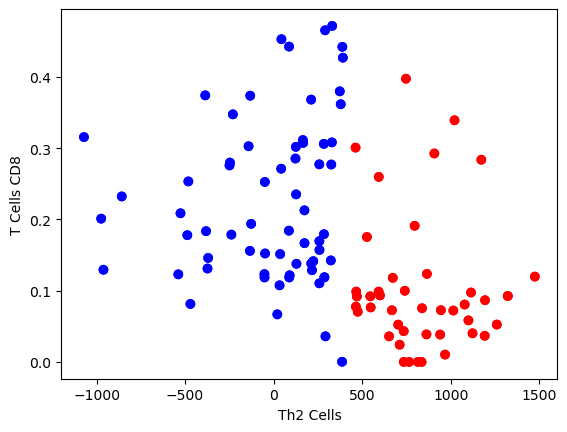

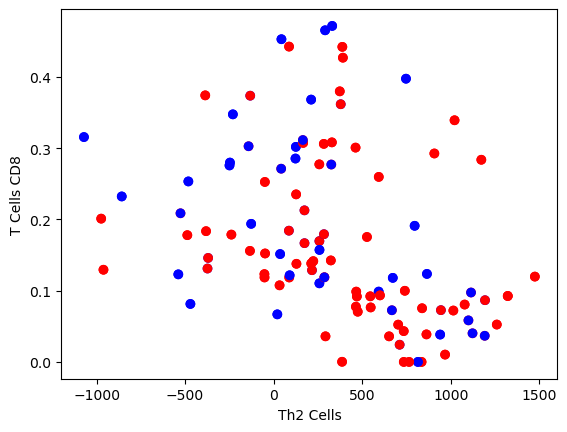

In [4]:
th2_bound = 439.13

# match index of repre and profile
tcgaskcm_profile = pd.read_csv("data/tcgaskcm/profile.csv").dropna(subset=["embd_fold"]).reset_index(drop=True)
tcgaskcm_repre = np.load("data/tcgaskcm/repre.npy")
stanford_profile = pd.read_csv("data/stanford/profile.csv")
stanford_repre = np.load("data/stanford/repre.npy")
# train
train_profile = tcgaskcm_profile[tcgaskcm_profile["train"] == 1]
train_repre = tcgaskcm_repre[train_profile.index]
train_label = train_profile["Th2 Cells"] > th2_bound
# valid
valid_profile = tcgaskcm_profile[tcgaskcm_profile["valid"] == 1]
valid_repre = tcgaskcm_repre[valid_profile.index]
valid_label = valid_profile["Th2 Cells"] > th2_bound
# add 23 standford samples into train_repre and train_label
#train_repre = np.concatenate([train_repre, stanford_repre])
#train_label = np.concatenate([train_label, stanford_profile["Treatment"] == "post anti-PD-1"])

# use logistic regression to fit train_repre and train_label
lr = sklearn.linear_model.LogisticRegression()
lr.fit(train_repre, train_label)
train_pred = lr.predict(train_repre)
print(sklearn.metrics.confusion_matrix(train_label, train_pred))
# predict valid_repre
valid_pred = lr.predict(valid_repre)
# calculate confusion matrix
print(sklearn.metrics.confusion_matrix(valid_label, valid_pred))

# plot valid x as "Th2 Cells", y as "T Cells CD8", color by valid_label
#plt.figure(figsize=(5, 5), dpi=300)
plt.scatter(valid_profile["Th2 Cells"], valid_profile["T Cells CD8"], c=["red" if l else "blue" for l in valid_label])
plt.xlabel("Th2 Cells")
plt.ylabel("T Cells CD8")
plt.show()
# plot valid x as "Th2 Cells", y as "T Cells CD8", color by valid_pred
#plt.figure(figsize=(5, 5), dpi=300)
plt.scatter(valid_profile["Th2 Cells"], valid_profile["T Cells CD8"], c=["red" if l else "blue" for l in valid_pred])
plt.xlabel("Th2 Cells")
plt.ylabel("T Cells CD8")
plt.show()

In [5]:
valid_profile["label"] = valid_label
valid_profile["pred"] = valid_pred
valid_easy_profile = valid_profile[valid_profile["easy"] == 1]
valid_hard_profile = valid_profile[valid_profile["hard"] == 1]
print(sklearn.metrics.confusion_matrix(valid_easy_profile["label"], valid_easy_profile["pred"]))
print(sklearn.metrics.confusion_matrix(valid_hard_profile["label"], valid_hard_profile["pred"]))

[[ 4  4]
 [ 8 14]]
[[52 69]
 [14 51]]


/tmp/ipykernel_1333814/1031057003.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_profile["label"] = valid_label
/tmp/ipykernel_1333814/1031057003.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_profile["pred"] = valid_pred


[0.21924287 0.02317552 0.0162647  0.00589764 0.00571105 0.00523205
 0.00514666 0.00506196 0.00498933 0.00485879]


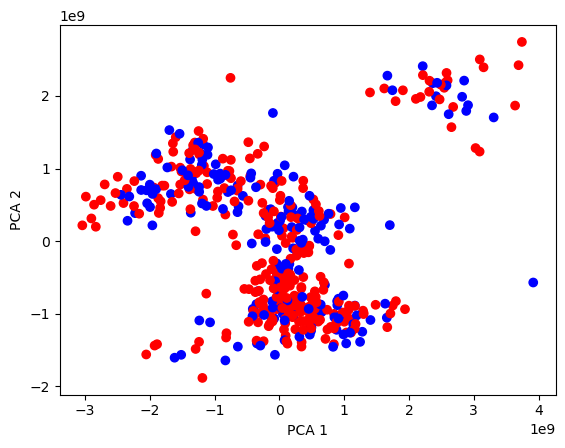

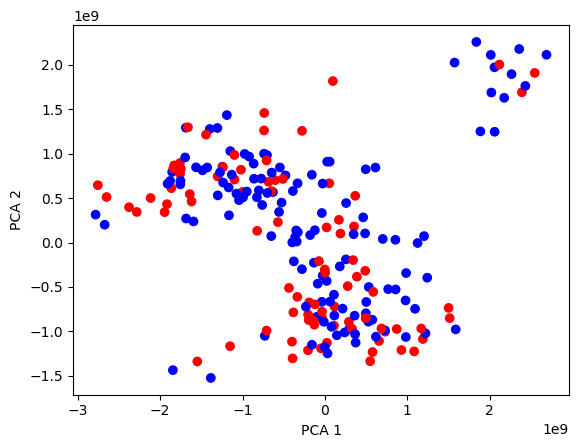

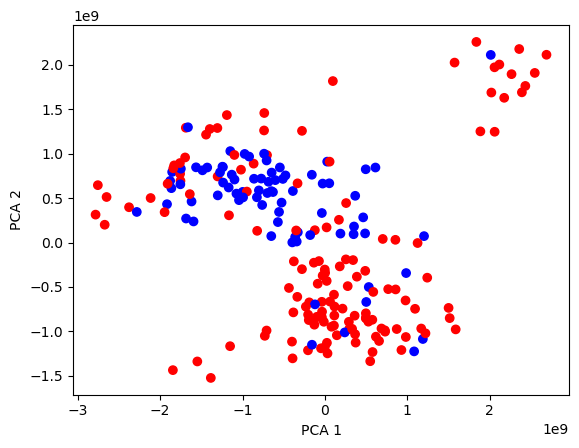

In [11]:
pca1 = 1
pca2 = 2

# pca (497, 131042) to (497, 2)
pca = sklearn.decomposition.PCA(n_components=10)
train_repre_pca = pca.fit_transform(train_repre)
print(pca.explained_variance_ratio_)
# plot pca 1 and pca 2, color by train_label
plt.scatter(train_repre_pca[:, pca1], train_repre_pca[:, pca2], c=["red" if l else "blue" for l in train_label])
plt.xlabel(f"PCA {pca1}")
plt.ylabel(f"PCA {pca2}")
plt.show()
valid_repre_pca = pca.transform(valid_repre)
plt.scatter(valid_repre_pca[:, pca1], valid_repre_pca[:, pca2], c=["red" if l else "blue" for l in valid_label])
plt.xlabel(f"PCA {pca1}")
plt.ylabel(f"PCA {pca2}")
plt.show()
valid_repre_pca = pca.transform(valid_repre)
plt.scatter(valid_repre_pca[:, pca1], valid_repre_pca[:, pca2], c=["red" if l else "blue" for l in valid_pred])
plt.xlabel(f"PCA {pca1}")
plt.ylabel(f"PCA {pca2}")
plt.show()